In [1]:
# Visualization of activity difference between a classical neural network and a FGnet
# shows that FGNs are trainable over multiple layers
# shows that FGNs have less linear seperation of space

# this notebook showcases classic linear+tanh feedforward nets and full FGN nets

# you can try various: Network sizes, dropout probs, lambdas in the losses, different 2d data sets

In [2]:
from __future__ import print_function

In [3]:
import matplotlib as mpl
# set this 'backend' when using jupyter; do this before importing pyplot
mpl.use('nbagg')
import matplotlib.pyplot as plt

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np
import scipy as sp
from scipy import stats
from sklearn import datasets as skdatasets
from sklearn.utils import shuffle as shuffle_in_unison


import sys
sys.path.append('/home/felix/Research/Adversarial Research/FGN---Research/')
import Finite_Gaussian_Network_lib as fgnl
import Finite_Gaussian_Network_lib.fgn_helper_lib as fgnh

In [5]:
!gpustat

crescent  Thu Sep 19 00:20:37 2019
[0] GeForce GTX 1080 | 81'C,  91 % |  8112 /  8119 MB | salami(2935M) felix(625M) denys(4329M) felix(211M)
[1] GeForce GTX 1080 | 79'C,  89 % |  6765 /  8119 MB | felix(563M) denys(2281M) soumi(3909M)


In [6]:
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
print("Using device:", device)

# manualy set cuda device
torch.cuda.set_device(1)

CUDA Available:  True
Using device: cuda


In [7]:
# # random seeds
# torch.manual_seed(999)
# np.random.seed(999)

# torch.backends.cudnn.deterministic = True
# torch.cuda.manual_seed_all(999)

In [8]:
total_num_samples = 2048

# random moons
samples, labels = skdatasets.make_moons(n_samples=total_num_samples, noise=0.2, shuffle=True)

# random concentric circles
# samples, labels = skdatasets.make_circles(n_samples=total_num_samples, noise=0.08, factor=0.4, shuffle=True)

# train/test split
ratio=4.0/5.0
split_index = int(len(samples)*ratio)

train_samples, train_labels = samples[:split_index], labels[:split_index]
test_samples, test_labels = samples[split_index:], labels[split_index:]


# add noise?
X1 = np.arange(-10.0, 10.01, 0.5)
X1s, X2s = np.meshgrid(X1,X1)
noise_samples = np.reshape(zip(X1s.flatten(),X2s.flatten()),(-1,2))
noise_labels = np.array([np.random.choice([0,1]) for _ in range(len(noise_samples))])


# train_samples = np.concatenate((train_samples ,noise_samples),axis=0)
# train_labels = np.concatenate((train_labels ,noise_labels),axis=0)

# train_samples = noise_samples
# train_labels = noise_labels

num_samples = len(train_samples)

<IPython.core.display.Javascript object>


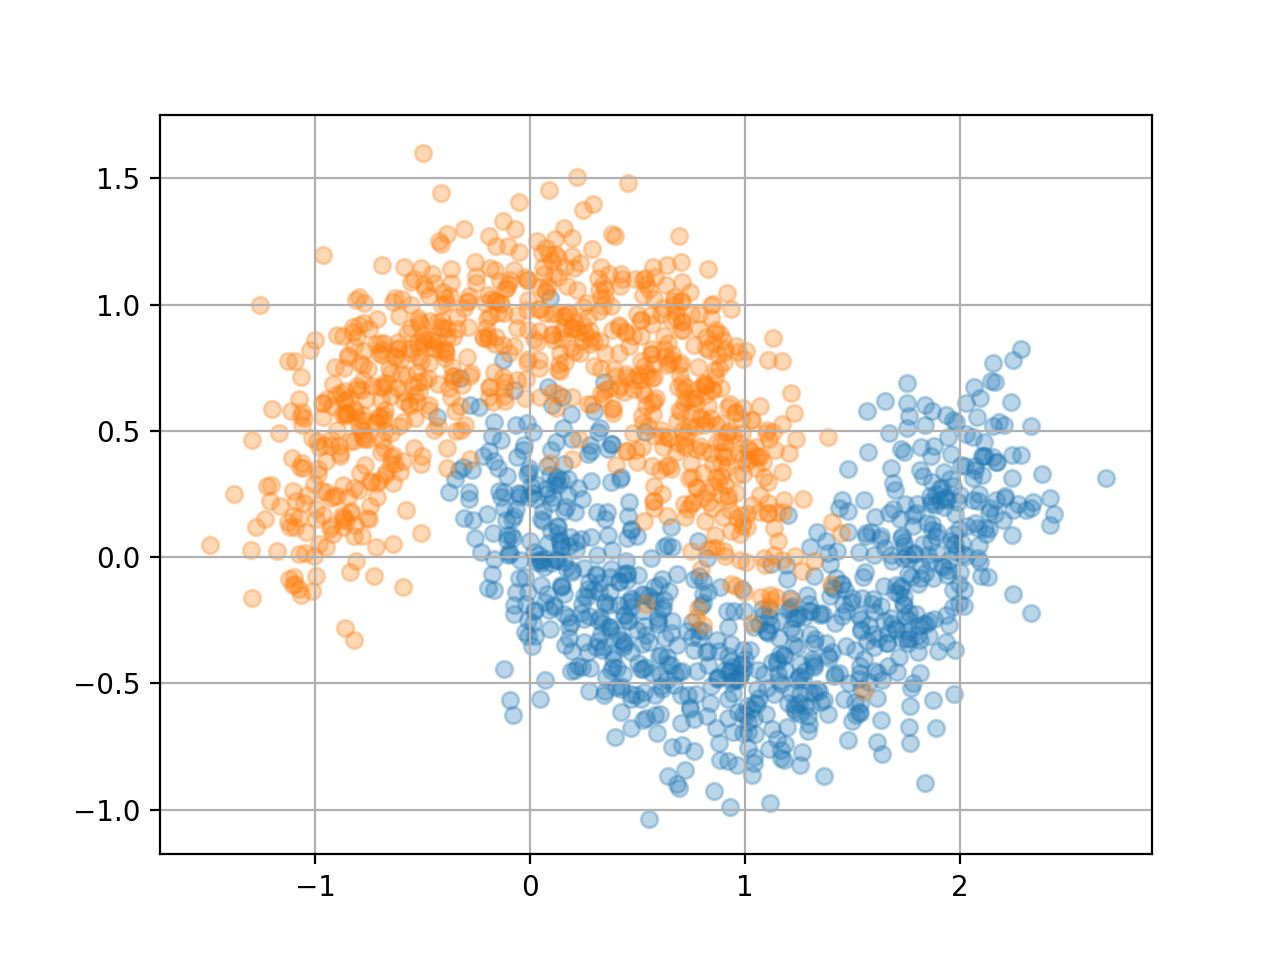

In [9]:
# 2D Check 
samples_x_1 = [x for x,l in zip(train_samples[:,0], train_labels) if l==0]
samples_y_1 = [y for y,l in zip(train_samples[:,1], train_labels) if l==0]

samples_x_2 = [x for x,l in zip(train_samples[:,0], train_labels) if l==1]
samples_y_2 = [y for y,l in zip(train_samples[:,1], train_labels) if l==1]

plt.scatter(samples_x_2, samples_y_2, alpha=0.3)
plt.scatter(samples_x_1, samples_y_1, alpha=0.3)

plt.grid(True)
plt.show()

In [10]:
# convert data to pytorch format 
tensor_train_x = torch.Tensor(train_samples)
tensor_train_y = torch.Tensor(train_labels)

tensor_test_x = torch.Tensor(test_samples)
tensor_test_y = torch.Tensor(test_labels)

my_dataset = torch.utils.data.TensorDataset(tensor_train_x, tensor_train_y) # create your dataset
my_test_data = torch.utils.data.TensorDataset(tensor_test_x,tensor_test_y) # create your dataset

my_dataloader = torch.utils.data.DataLoader(my_dataset, batch_size=192, shuffle=True) # create your dataloader
my_test_dataloader = torch.utils.data.DataLoader(my_test_data, shuffle=True) # create your dataloader

In [11]:
### PART 1: classic feedforward net (linear with bias + tanh)

In [12]:
# loss functions for the classic net
lmbda_l2 = (4.0*0.1/len(my_dataloader.dataset))
print(lmbda_l2)
      
classical_cross_ent_loss = fgnh.def_classical_cross_ent_loss(lmbda_l2)

0.0002442002442


In [13]:
# Initialize the classic network
hidden_layer_sizes = [32]
drop_p = 0.2

In [14]:
classic_model = fgnl.Feedforward_Classic_net(in_feats=2, out_feats=2, hidden_layer_sizes=hidden_layer_sizes, drop_p=drop_p).to(device)

In [15]:
# define model params to optimize
classic_optimizer = optim.Adam(filter(lambda p: p.requires_grad, classic_model.parameters()), lr=0.05)
# classic_optimizer = optim.RMSprop(filter(lambda p: p.requires_grad, classic_model.parameters()),momentum=0.5)

In [16]:
epochs = 5

In [17]:
# train the network for N epochs
print("# epochs:", epochs)
classic_train_res = fgnh.train(classic_model, my_dataloader, 
                             classical_cross_ent_loss, classic_optimizer, epochs, save_hist=2, verbose=True, 
                             pred_func=fgnh.cross_ent_pred_accuracy, test_loader=my_test_dataloader)

# epochs: 5
Epoch 0 Train set - Average loss: 0.4563, Accuracy: 1276/1638 (78%)
Test set - Average loss: 0.4657, Accuracy: 330/410 (80%)
Epoch 1 Train set - Average loss: 0.3822, Accuracy: 1347/1638 (82%)
Test set - Average loss: 0.3880, Accuracy: 360/410 (88%)
Epoch 2 Train set - Average loss: 0.3669, Accuracy: 1337/1638 (82%)
Test set - Average loss: 0.3132, Accuracy: 351/410 (86%)
Epoch 3 Train set - Average loss: 0.3488, Accuracy: 1367/1638 (83%)
Test set - Average loss: 0.2991, Accuracy: 359/410 (88%)
Epoch 4 Train set - Average loss: 0.3376, Accuracy: 1357/1638 (83%)
Test set - Average loss: 0.2755, Accuracy: 358/410 (87%)


In [18]:
# test the statibility of the model (these numbers should be same as final lines above)
classic_test_res = fgnh.test(classic_model, my_dataloader,
                        classical_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

classic_test_res = fgnh.test(classic_model, my_test_dataloader,
                        classical_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

Test set - Average loss: 0.2622, Accuracy: 1472/1638 (90%)
Test set - Average loss: 0.2755, Accuracy: 358/410 (87%)


In [19]:
# scale of the heat maps
X1 = np.arange(-10.0, 10.01, 0.1)
X1s, X2s = np.meshgrid(X1,X1)
heatmap_inputs = np.reshape(zip(X1s.flatten(),X2s.flatten()),(-1,2))
print("shape of heatmap", np.shape(heatmap_inputs))
heatmap_inputs = torch.Tensor(heatmap_inputs)
print(type(heatmap_inputs))
# print(heatmap_inputs)

shape of heatmap (40401, 2)
<class 'torch.Tensor'>


In [20]:
# compute predictions for heatmap
classic_model.eval()
classic_heatmap_preds = classic_model(heatmap_inputs.to(device))
classic_heatmap_preds = classic_heatmap_preds.cpu().detach().numpy()
# apply softmax for probs
classic_heatmap_preds_softmax = np.array([np.exp(x)/sum(np.exp(x)) for x in classic_heatmap_preds])

<IPython.core.display.Javascript object>


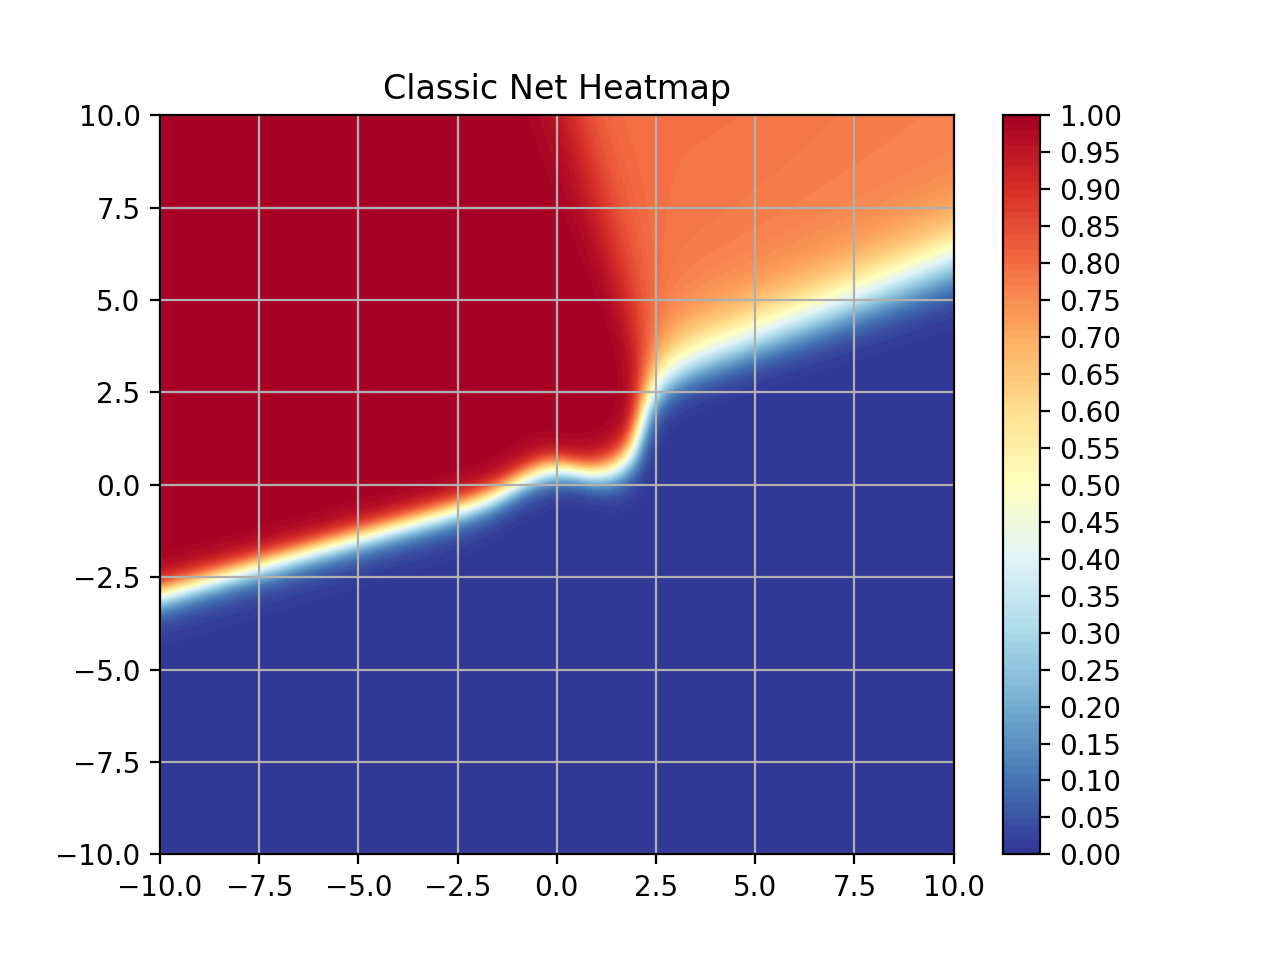

In [21]:
# plot the heatmap
levels = np.arange(-0, 1.0+0.001, 10**(-2))
ticks = levels[::5]

plt.contourf(X1s, X2s, np.reshape(classic_heatmap_preds_softmax[:,0], np.shape(X1s) ),levels=levels, cmap= mpl.cm.RdYlBu_r)
plt.colorbar(ticks=ticks)

# # uncomment if you want to see the data and tighten the window
# plt.scatter(samples_x_1, samples_y_1, alpha=0.1, c='gray')
# plt.scatter(samples_x_2, samples_y_2, alpha=0.1, c='gray')
# plt.axis([-1.5,2.5, -1, 1.5])

plt.title("Classic Net Heatmap")
plt.grid(True)
plt.show()

In [22]:
### PART 2: fully FGN network

In [23]:
### Loss Functions for the FGN

# importances of the constraints
lmbda_l2 = (4.0*0.1/len(my_dataloader.dataset))
lmbda_sigs = 1.0*lmbda_l2
# sig_params = sum(p.numel() for n,p in fgn_model.named_parameters() if 'sigs' in n)
# lmbda_sigs = (1.0/sig_params)

# lmbda_l2 = 0.0
# lmbda_sigs = 0.0
print("lambda for l2 loss", lmbda_l2)
print("lambda for sigs^2 loss", lmbda_sigs)


fgn_cross_ent_loss = fgnl.def_fgn_cross_ent_loss(lmbda_l2, lmbda_sigs)


lambda for l2 loss 0.0002442002442
lambda for sigs^2 loss 0.0002442002442


In [24]:
# fgn specific params
print("hidden layers:", hidden_layer_sizes)
# covariance type: sphere, diag or full
covar_type = 'diag'
print("covariance:", covar_type)
ordinal = float(2)
print("ordinal for norm:", ordinal)
non_lin = torch.tanh
print("non linearity", non_lin)
print("drop prob:", drop_p)
noisy_centers = False
print("noisy centers:", noisy_centers)
random_eval = False
print("Random Eval", random_eval)

# Initialize the fgn network
fgn_model = fgnl.Feedforward_FGN_net(in_feats=2, out_feats=2, hidden_layer_sizes=hidden_layer_sizes, drop_p=drop_p,
                                     covar_type=covar_type, ordinal=ordinal,
                                     noisy_centers=noisy_centers, non_lin=non_lin).to(device)

hidden layers: [32]
covariance: diag
ordinal for norm: 2.0
non linearity <built-in function tanh>
drop prob: 0.2
noisy centers: False
Random Eval False


In [25]:
# define model params to optimize
fgn_optimizer = optim.Adam(filter(lambda p: p.requires_grad, fgn_model.parameters()), lr=0.05)
# fgn_optimizer = optim.RMSprop(filter(lambda p: p.requires_grad, fgn_model.parameters()),momentum=0.1)

In [26]:
# train the network for N epochs
fgn_train_res = fgnh.train(fgn_model, my_dataloader, 
                             fgn_cross_ent_loss, fgn_optimizer, epochs, save_hist=2, verbose=True, 
                             pred_func=fgnh.cross_ent_pred_accuracy, test_loader=my_test_dataloader)

Epoch 0 Train set - Average loss: 0.7505, Accuracy: 1095/1638 (67%)
Test set - Average loss: 0.7026, Accuracy: 227/410 (55%)
Epoch 1 Train set - Average loss: 0.5395, Accuracy: 1249/1638 (76%)
Test set - Average loss: 0.4806, Accuracy: 344/410 (84%)
Epoch 2 Train set - Average loss: 0.4519, Accuracy: 1335/1638 (82%)
Test set - Average loss: 0.4088, Accuracy: 343/410 (84%)
Epoch 3 Train set - Average loss: 0.4317, Accuracy: 1361/1638 (83%)
Test set - Average loss: 0.3248, Accuracy: 375/410 (91%)
Epoch 4 Train set - Average loss: 0.4012, Accuracy: 1398/1638 (85%)
Test set - Average loss: 0.3292, Accuracy: 388/410 (95%)


In [27]:
# test the statibility of the model (these numbers should be close as final lines above, depending)
fgn_model.set_random_eval(False)
fgn_test_res = fgnh.test(fgn_model, my_dataloader,
                        fgn_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

fgn_test_res = fgnh.test(fgn_model, my_test_dataloader,
                        fgn_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

fgn_model.set_random_eval(True)
fgn_test_res = fgnh.test(fgn_model, my_dataloader,
                        fgn_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

fgn_test_res = fgnh.test(fgn_model, my_test_dataloader,
                        fgn_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

Test set - Average loss: 0.3288, Accuracy: 1539/1638 (94%)
Test set - Average loss: 0.3292, Accuracy: 388/410 (95%)
Test set - Average loss: 0.3288, Accuracy: 1539/1638 (94%)
Test set - Average loss: 0.3292, Accuracy: 388/410 (95%)


In [28]:
# compute predictions for heatmap with non-random eval
fgn_model.eval()
fgn_model.set_random_eval(False)
fgn_heatmap_preds = fgn_model(heatmap_inputs.to(device))
fgn_heatmap_preds = fgn_heatmap_preds.cpu().detach().numpy()
# apply softmax for probs
fgn_heatmap_preds_softmax = np.array([np.exp(x)/sum(np.exp(x)) for x in fgn_heatmap_preds.astype('float128')])

<IPython.core.display.Javascript object>


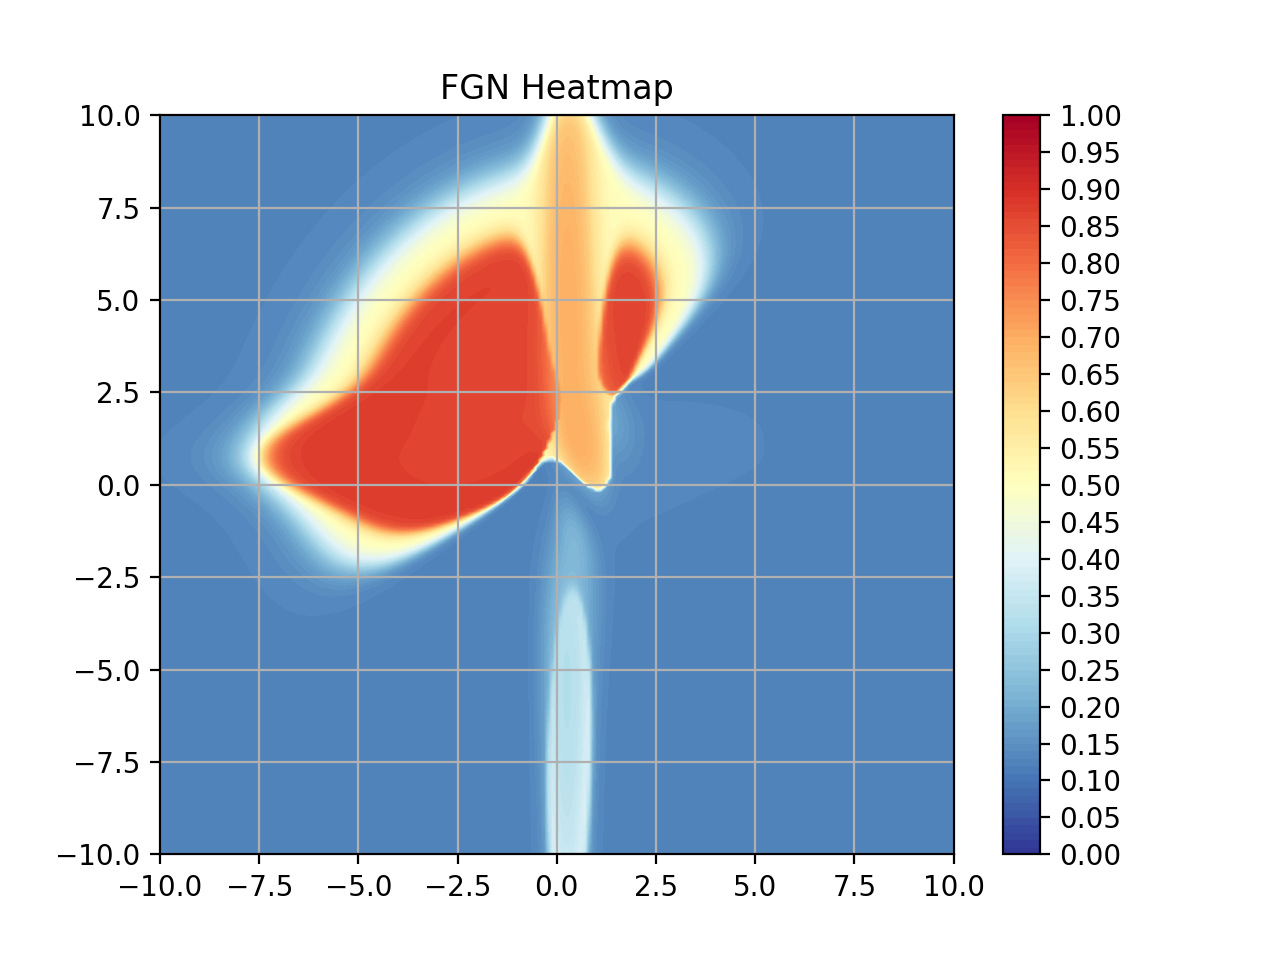

In [29]:
# plot the heatmap
levels = np.arange(-0.0, 1.0+0.001, 10**(-2))
ticks = levels[::5]

plt.contourf(X1s, X2s, np.reshape(fgn_heatmap_preds_softmax[:,0], np.shape(X1s) ),levels=levels, cmap= mpl.cm.RdYlBu_r)
plt.colorbar(ticks=ticks)

# # uncomment if you want to see the data and tighten the window
# plt.scatter(samples_x_1, samples_y_1, alpha=0.1, c='gray')
# plt.scatter(samples_x_2, samples_y_2, alpha=0.1, c='gray')
# plt.axis([-1.5,2.5, -1, 1.5])

plt.title("FGN Heatmap")
plt.grid(True)
plt.show()

In [30]:
# compute predictions for heatmap with random eval
fgn_model.set_random_eval(True)
fgn_model = fgn_model.eval()
fgn_heatmap_preds = fgn_model(heatmap_inputs.to(device))
fgn_heatmap_preds = fgn_heatmap_preds.cpu().detach().numpy()
# apply softmax for probs
fgn_heatmap_preds_softmax = np.array([np.exp(x)/sum(np.exp(x)) for x in fgn_heatmap_preds.astype('float128')])

<IPython.core.display.Javascript object>


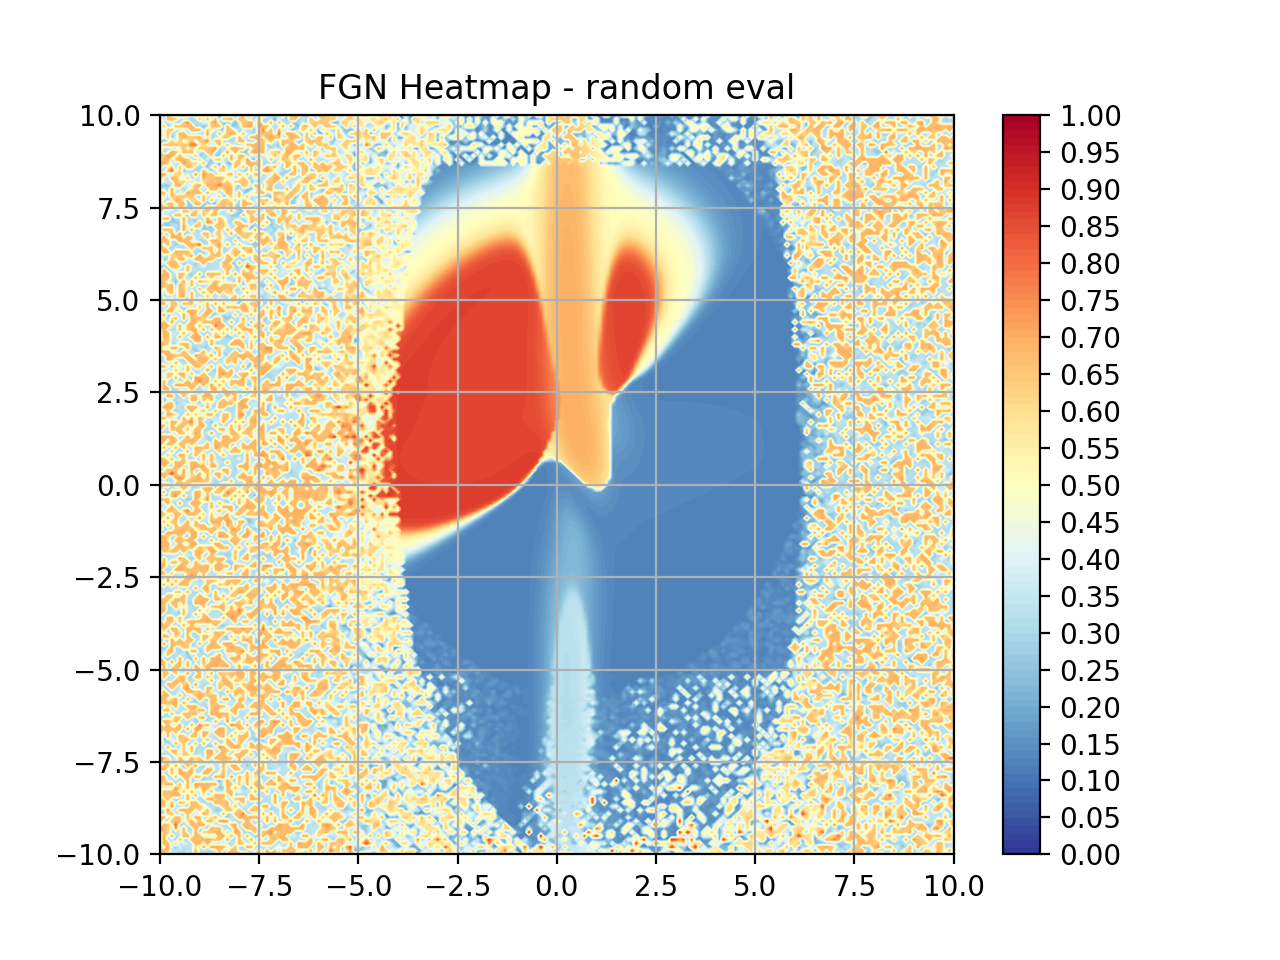

In [31]:
# plot the heatmap
levels = np.arange(-0.0, 1.0+0.001, 10**(-2))
ticks = levels[::5]

plt.contourf(X1s, X2s, np.reshape(fgn_heatmap_preds_softmax[:,0], np.shape(X1s) ),levels=levels, cmap= mpl.cm.RdYlBu_r)
plt.colorbar(ticks=ticks)

# # uncomment if you want to see the data and tighten the window
# plt.scatter(samples_x_1, samples_y_1, alpha=0.1, c='gray')
# plt.scatter(samples_x_2, samples_y_2, alpha=0.1, c='gray')
# plt.axis([-1.5,2.5, -1, 1.5])

plt.title("FGN Heatmap - random eval")
plt.grid(True)
plt.show()

<IPython.core.display.Javascript object>


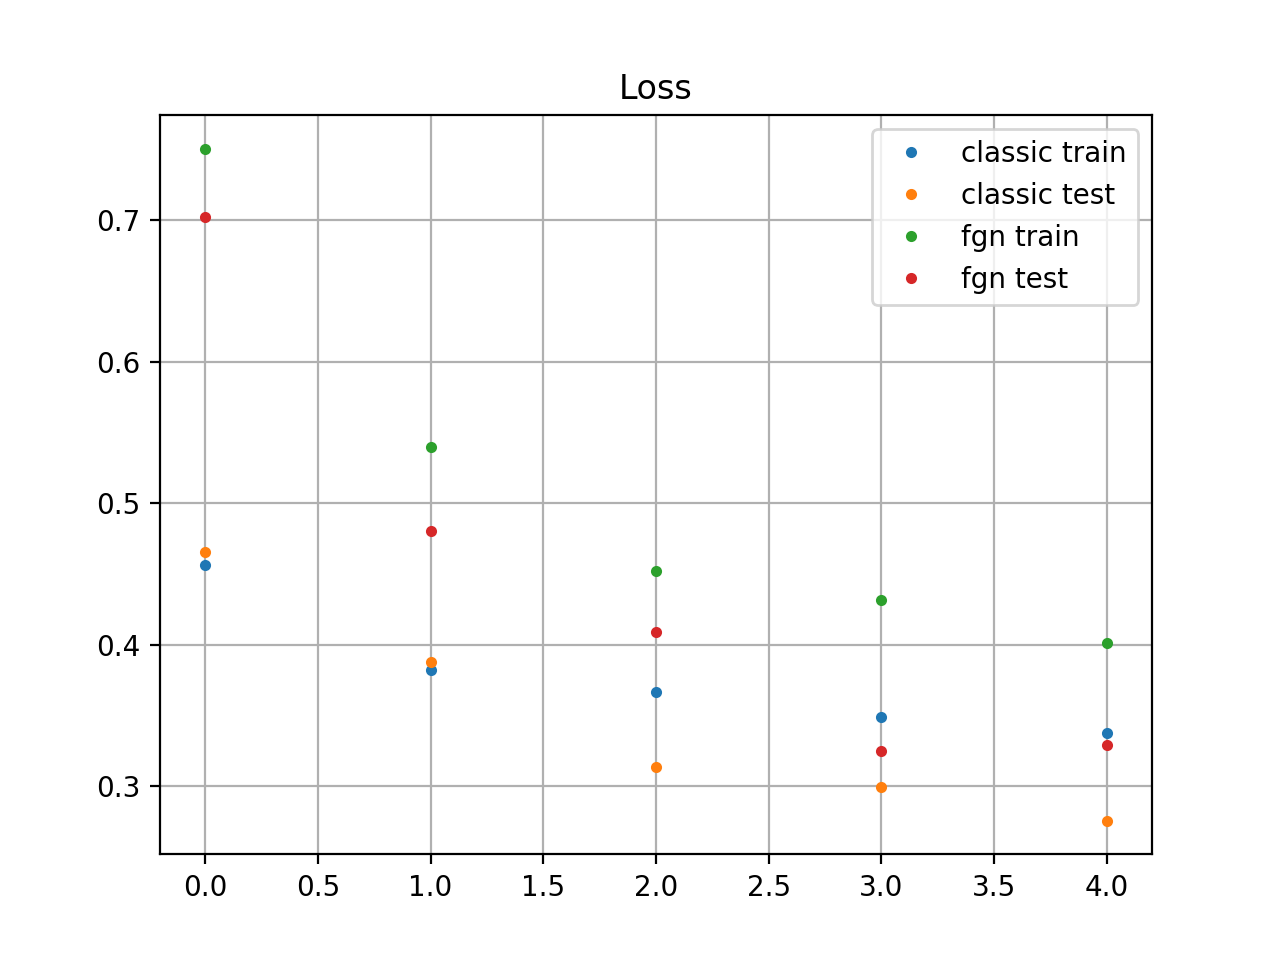

<IPython.core.display.Javascript object>


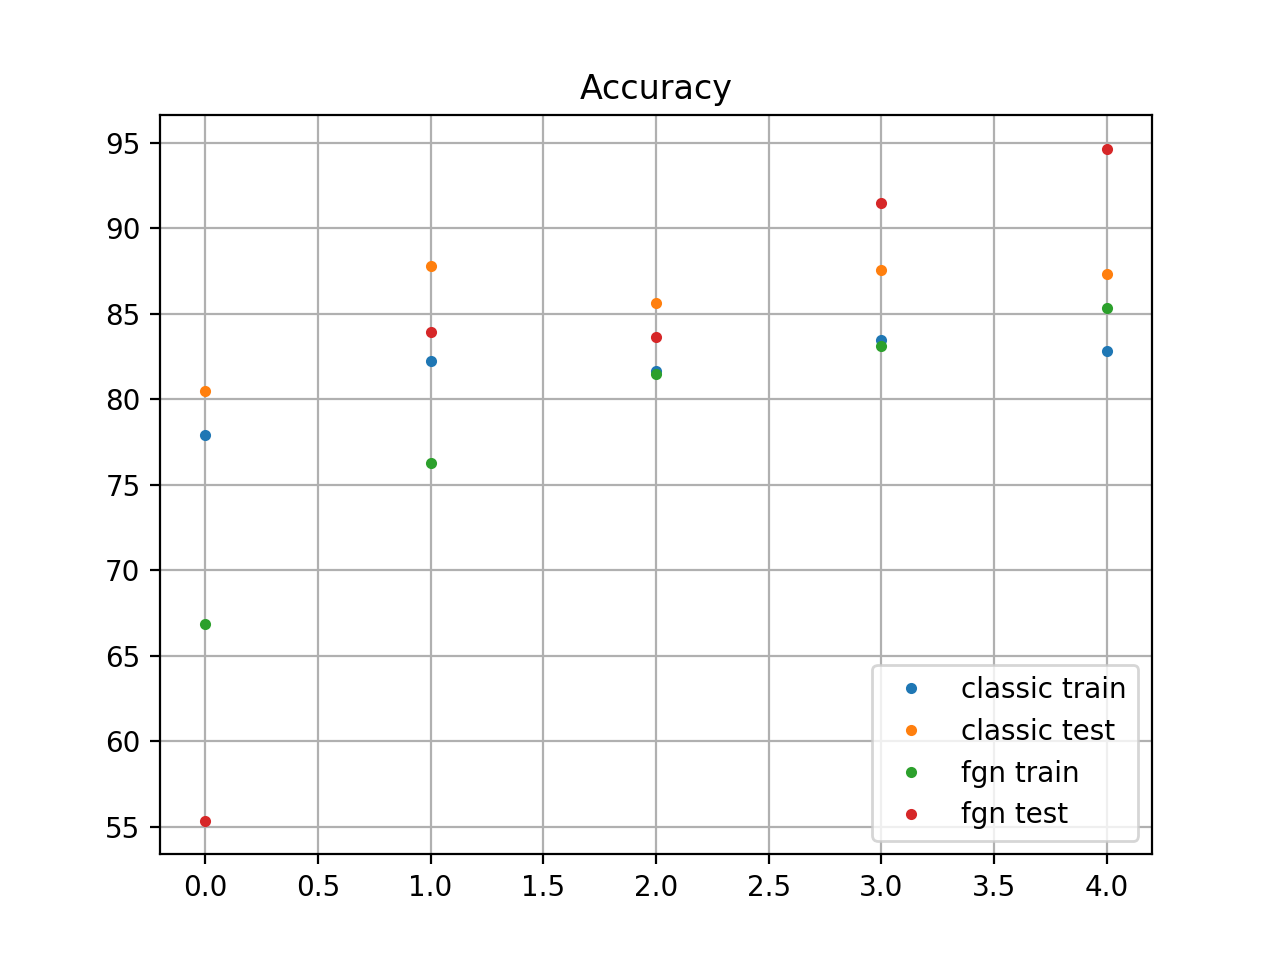

In [32]:
# acc and loss hist
plt.plot(classic_train_res['train_loss_hist'], marker='.', linestyle=' ', label='classic train')
plt.plot(classic_train_res['test_loss_hist'], marker='.', linestyle=' ', label='classic test')
plt.plot(fgn_train_res['train_loss_hist'], marker='.', linestyle=' ', label='fgn train')
plt.plot(fgn_train_res['test_loss_hist'], marker='.', linestyle=' ', label='fgn test')
plt.grid()
plt.legend()
plt.title('Loss')
plt.show()

plt.plot(classic_train_res['train_acc_hist'], marker='.', linestyle=' ', label='classic train')
plt.plot(classic_train_res['test_acc_hist'], marker='.', linestyle=' ', label='classic test')
plt.plot(fgn_train_res['train_acc_hist'], marker='.', linestyle=' ', label='fgn train')
plt.plot(fgn_train_res['test_acc_hist'], marker='.', linestyle=' ', label='fgn test')
plt.grid()
plt.legend()
plt.title('Accuracy')
plt.show()

In [33]:
### plot some FGN param movement during training

hidden_layers.1.centers
plotting neurons: [20 22]


<IPython.core.display.Javascript object>


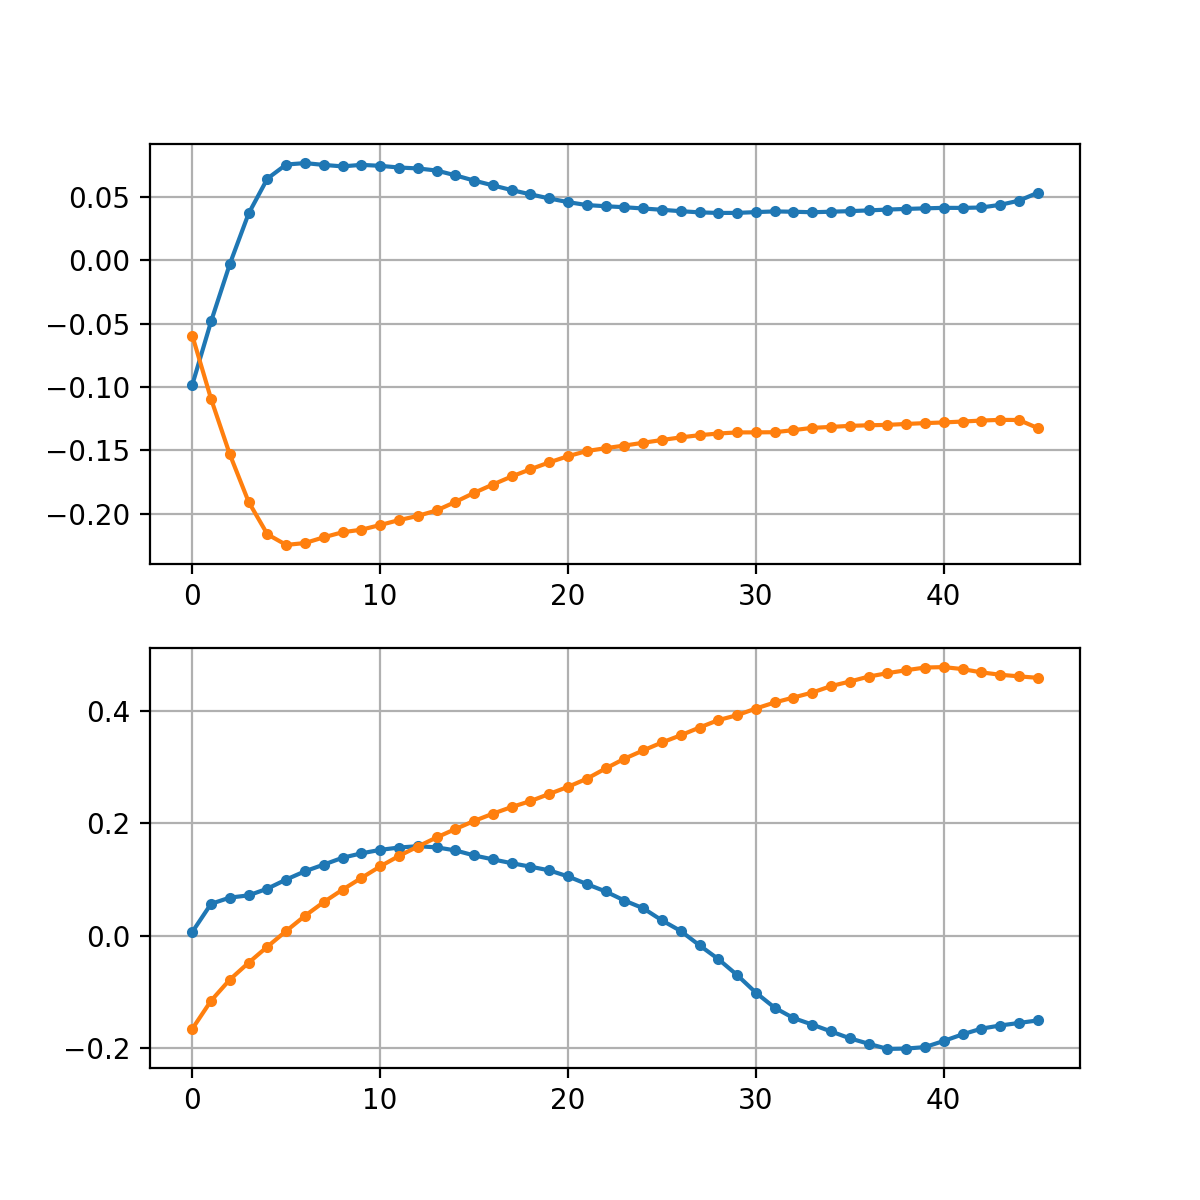

fl.centers
plotting neurons: [0 1]


<IPython.core.display.Javascript object>


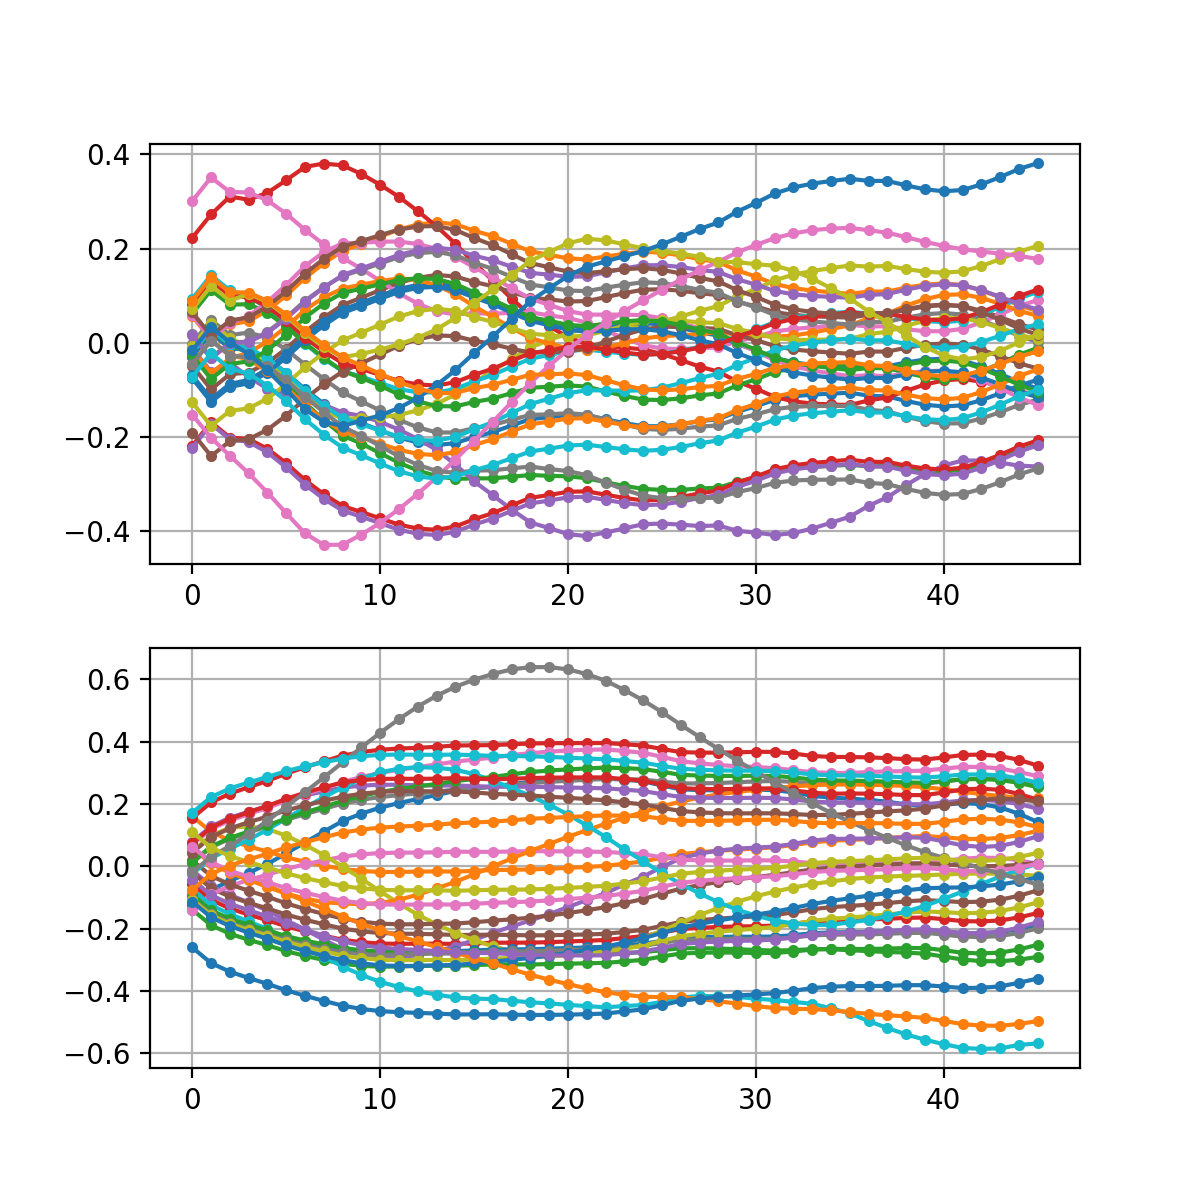

In [34]:
# plot centers history for only some hidden layer neuron
# for full FGN
for k in fgn_train_res['histories'].keys():
    if 'centers' in k:
        print(k)
        plt.figure(figsize=(6,6))
        # print(np.shape(fgn_fgn_train_res['histories'][k]))
        # choose 4random neurons in the layer to print
        neurons =  np.random.choice(range(np.shape(fgn_train_res['histories'][k])[1]),2, replace=False)
        print("plotting neurons:", neurons)
        # plt.figure(figsize=(2,2))

        for idx,n in enumerate(neurons):
            x = fgn_train_res['histories'][k][:,n,:]
            # print(np.shape(x))
            plt.subplot(2,1,idx+1)
            plt.plot(x, marker='.', linestyle='-')
            # plt.axis([-3,3, -3, 3])
            plt.grid()
        plt.show()

fl.inv_covar
(46, 2, 32)
plotting neurons: [1 0]


<IPython.core.display.Javascript object>


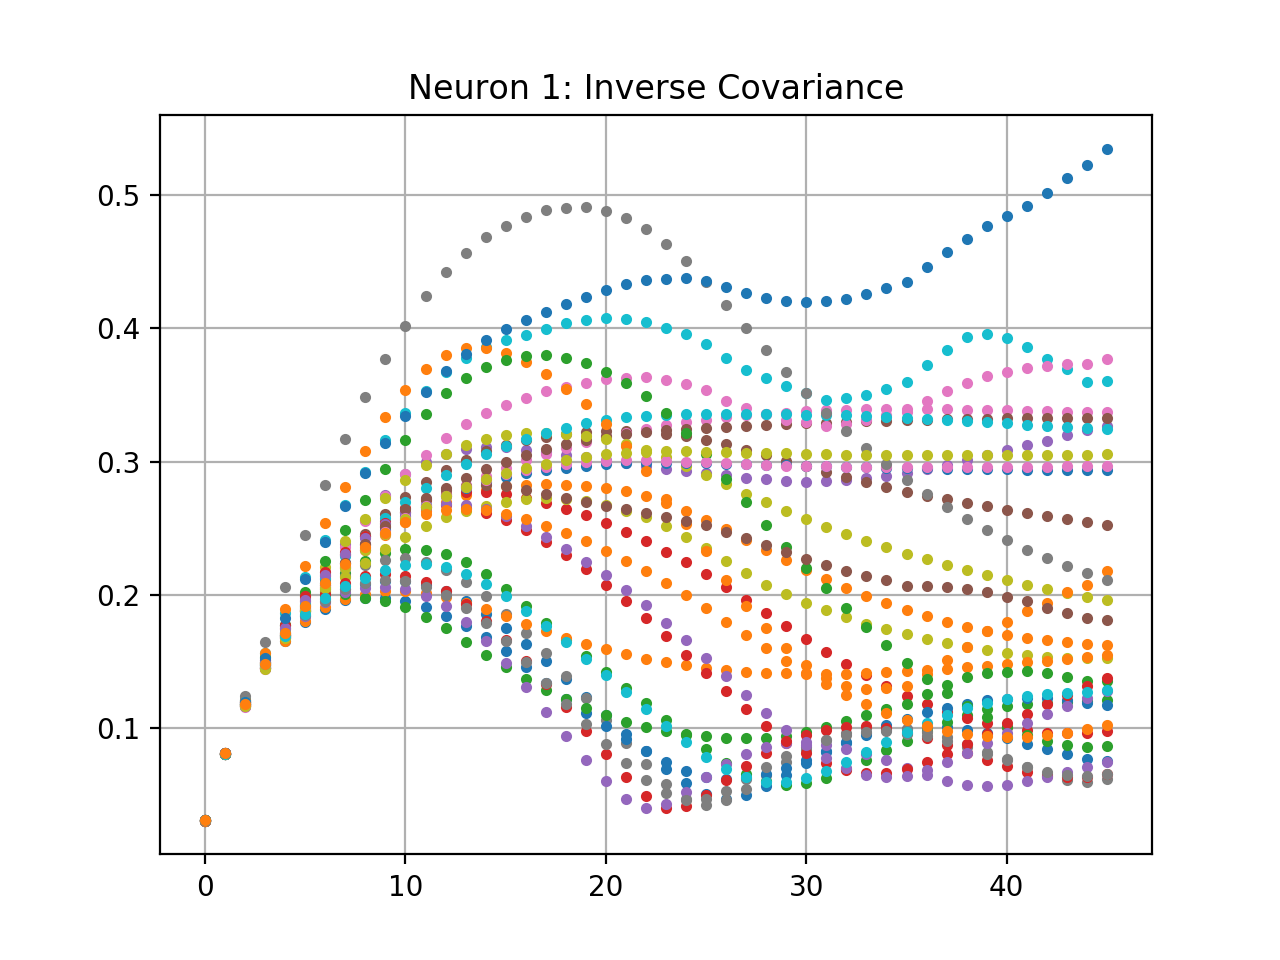

<IPython.core.display.Javascript object>


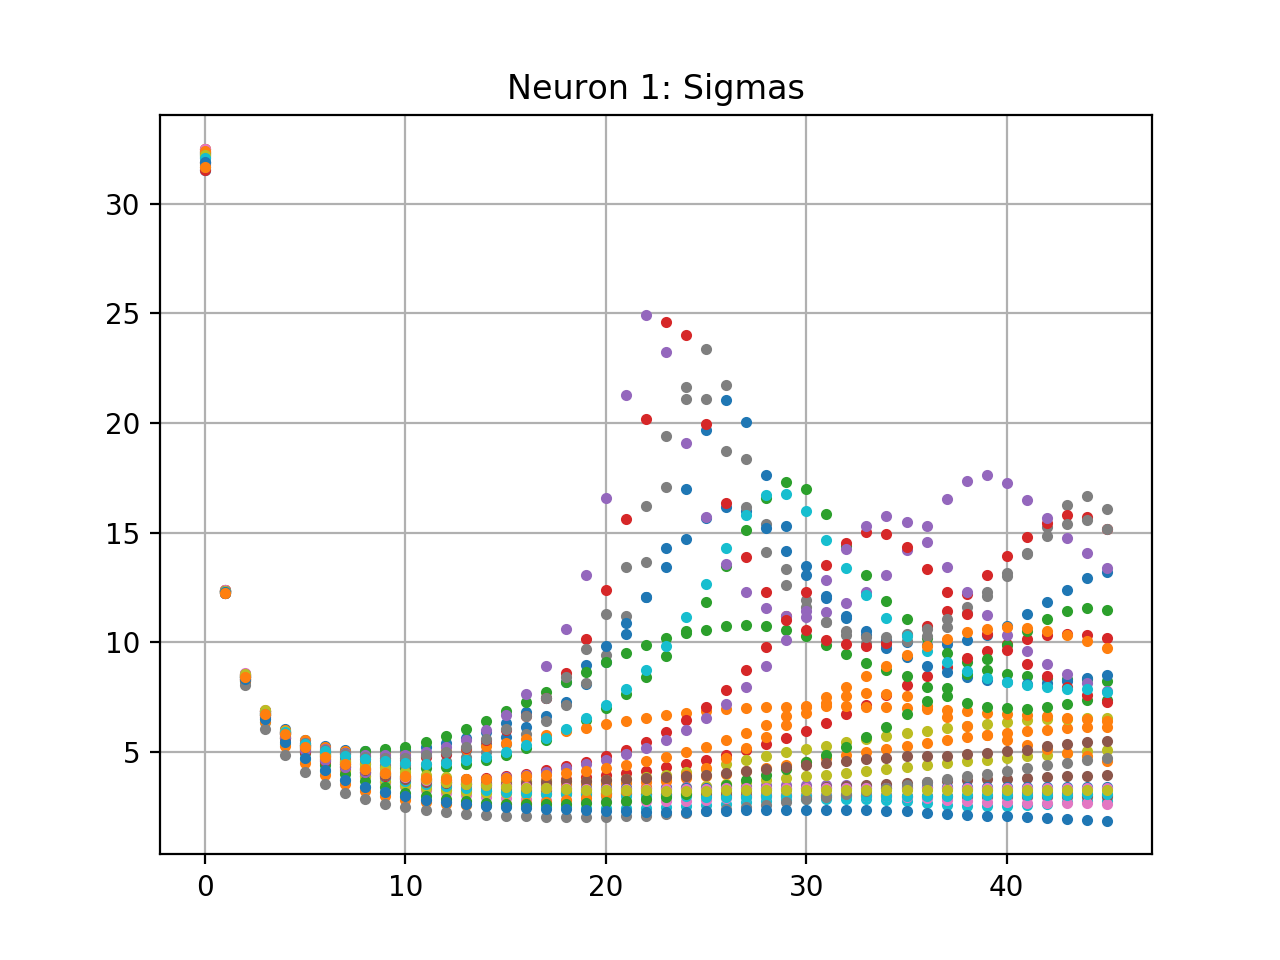

<IPython.core.display.Javascript object>


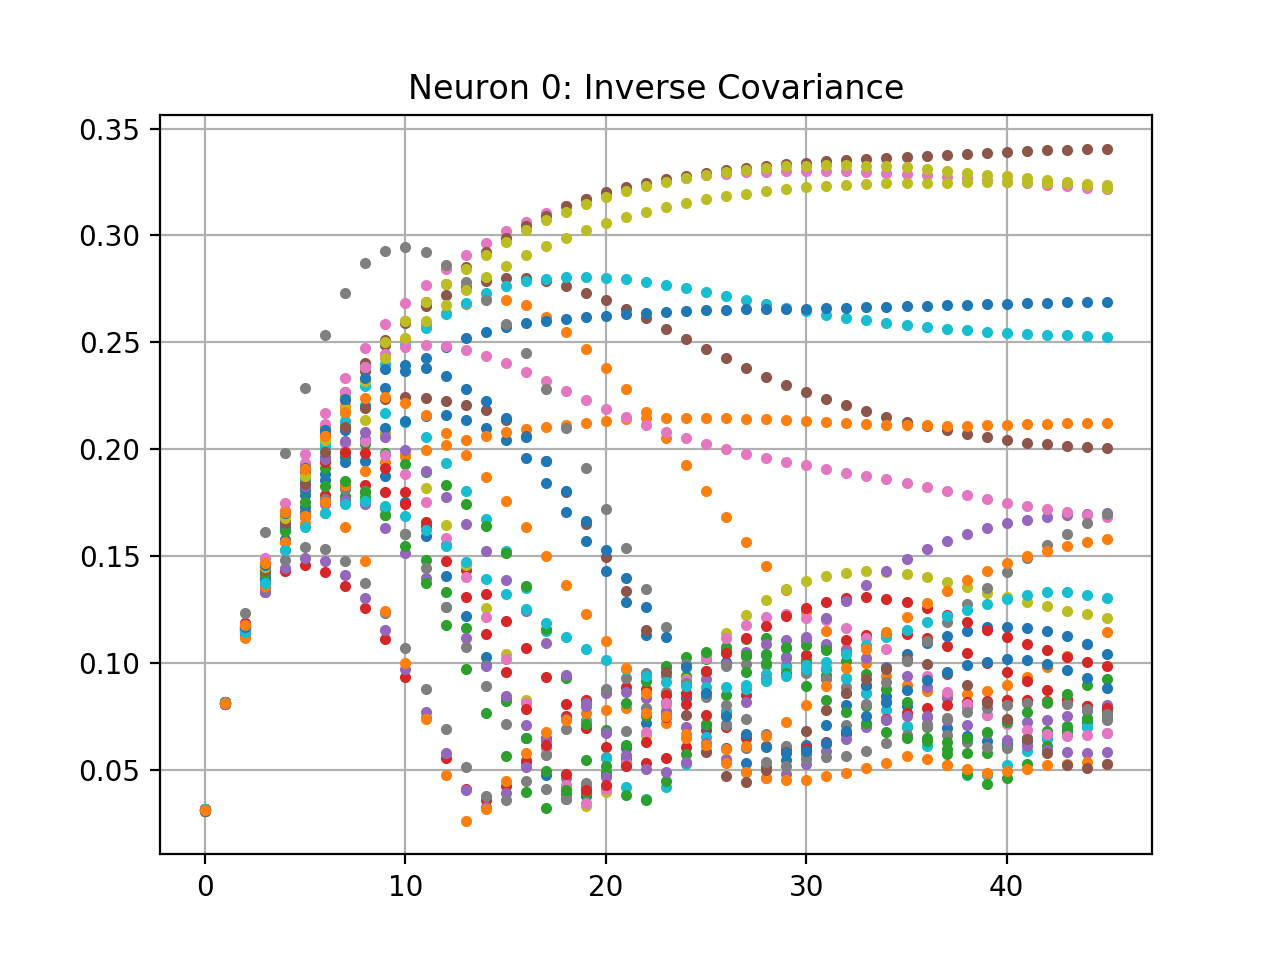

<IPython.core.display.Javascript object>


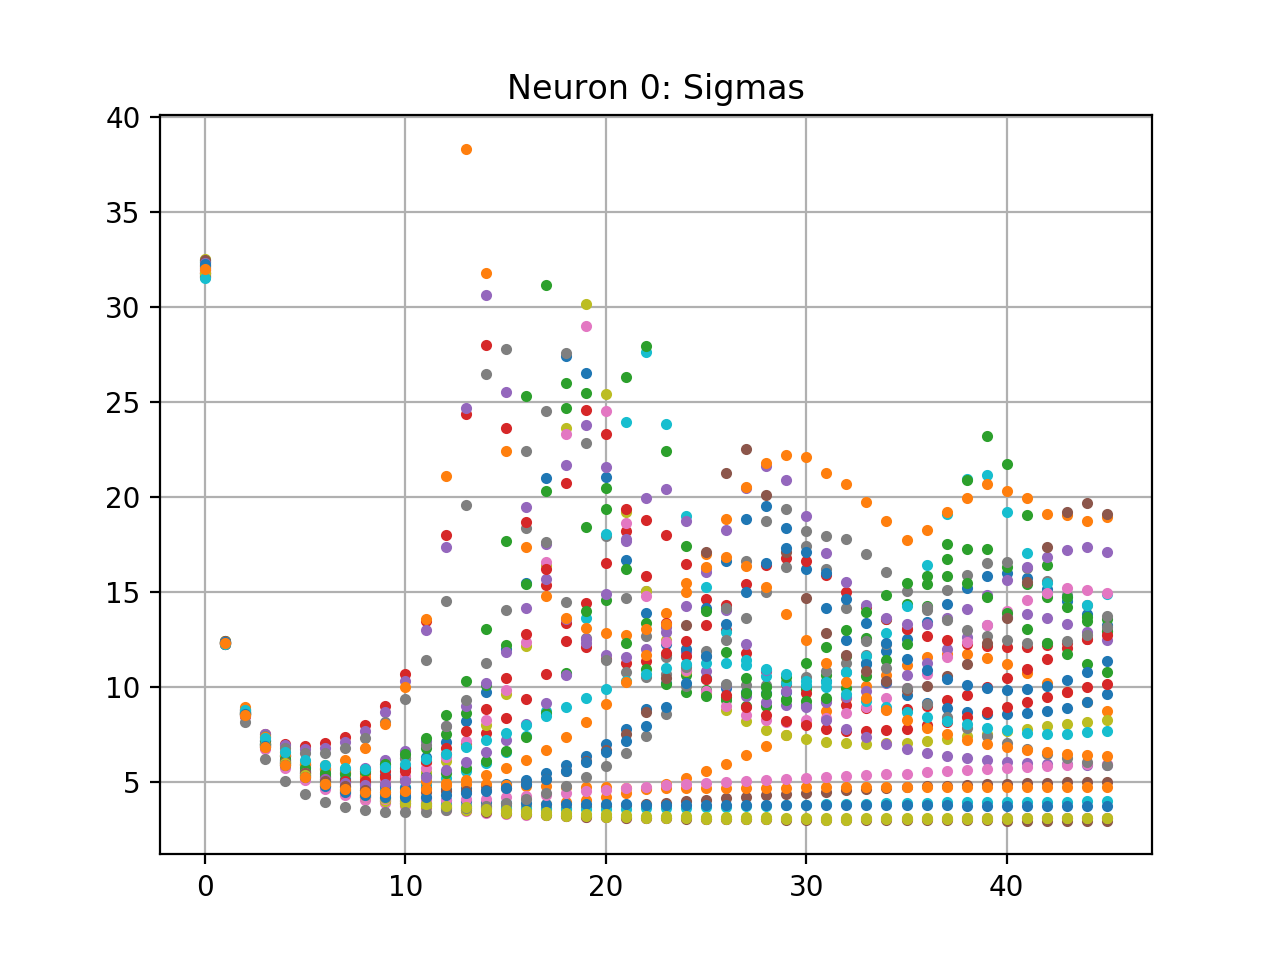

hidden_layers.1.inv_covar
(46, 32, 2)
plotting neurons: [21 27]


<IPython.core.display.Javascript object>


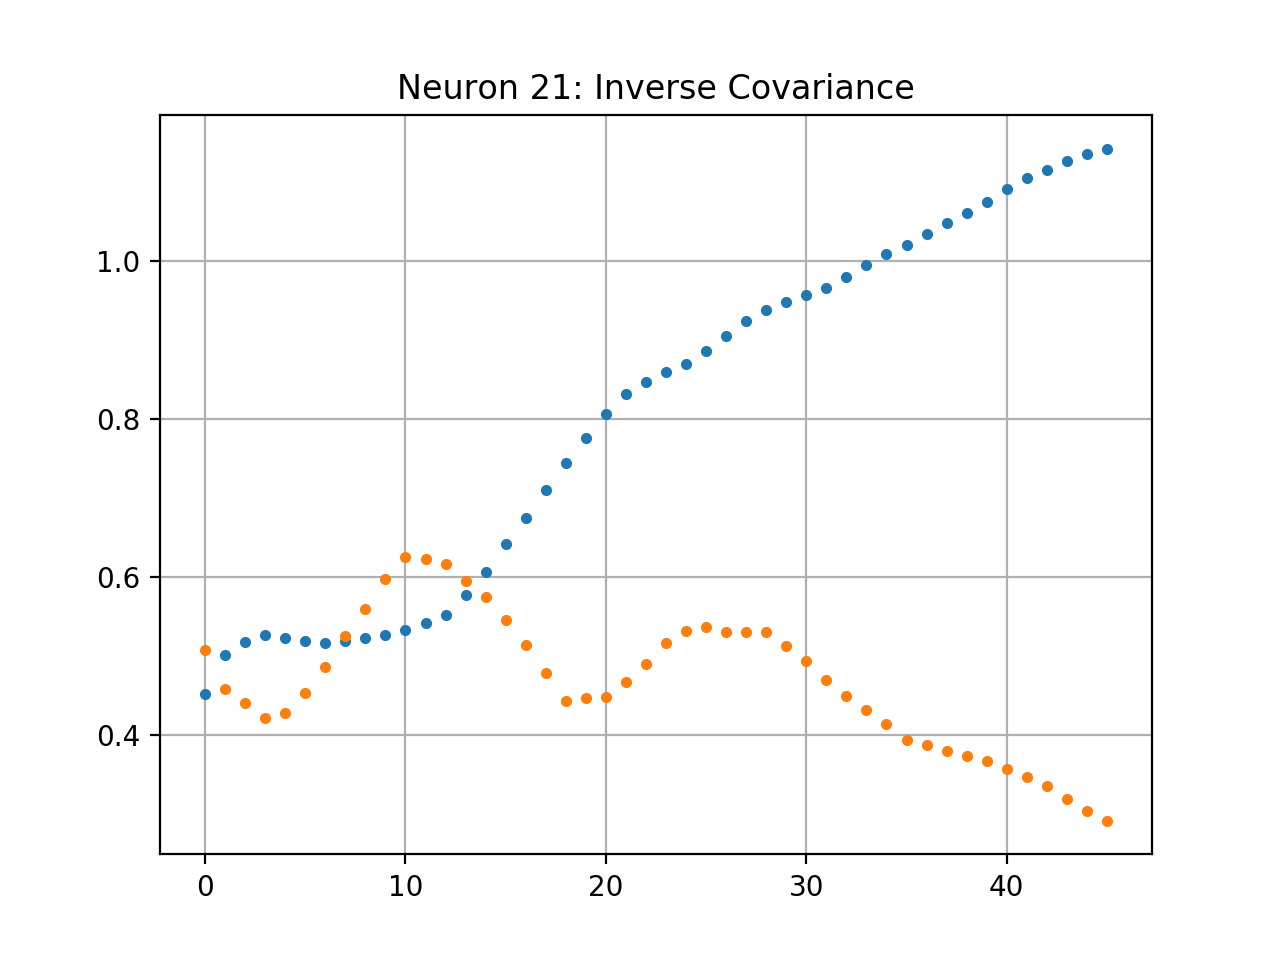

<IPython.core.display.Javascript object>


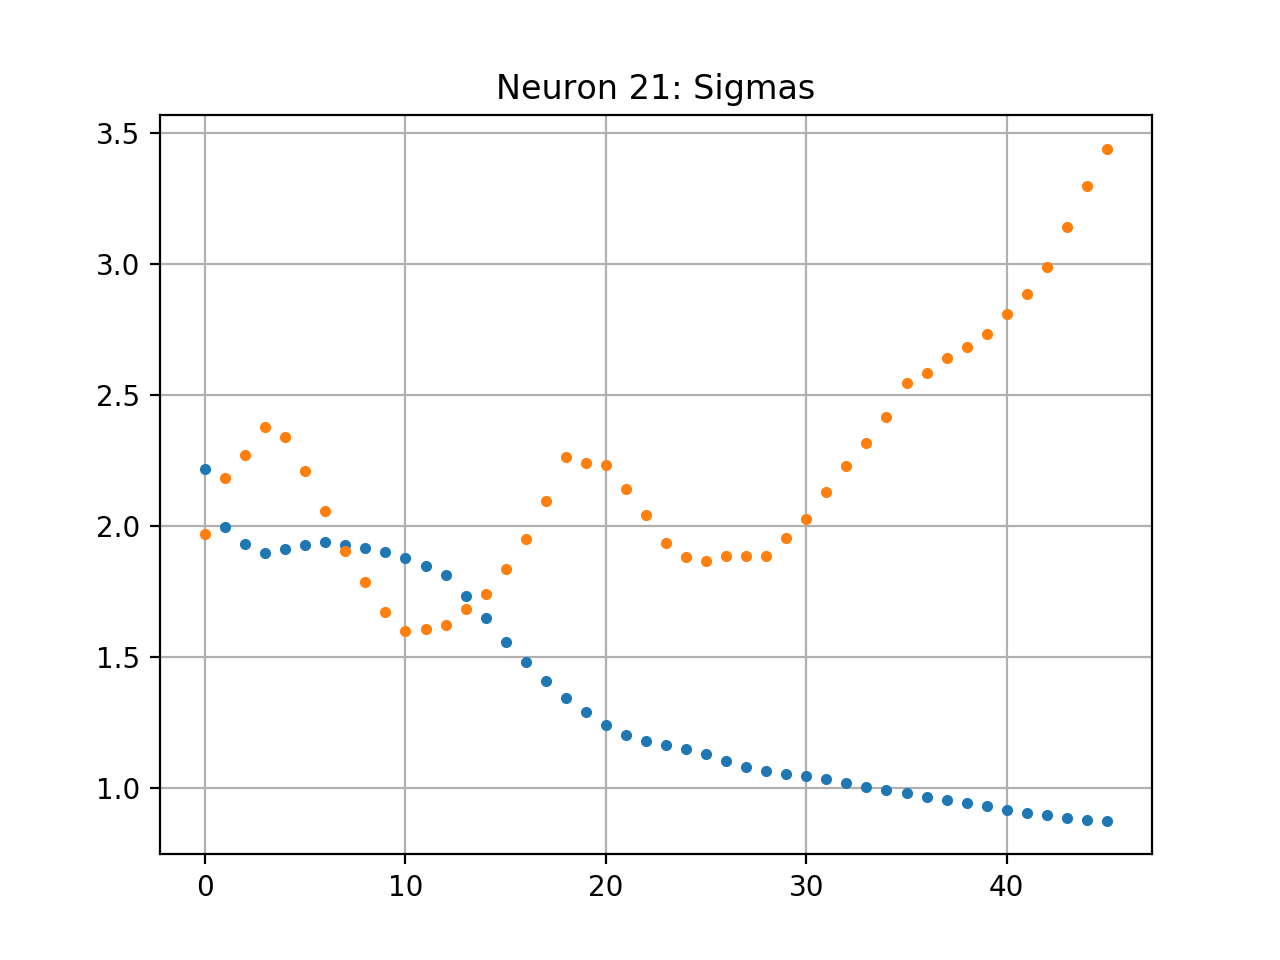

<IPython.core.display.Javascript object>


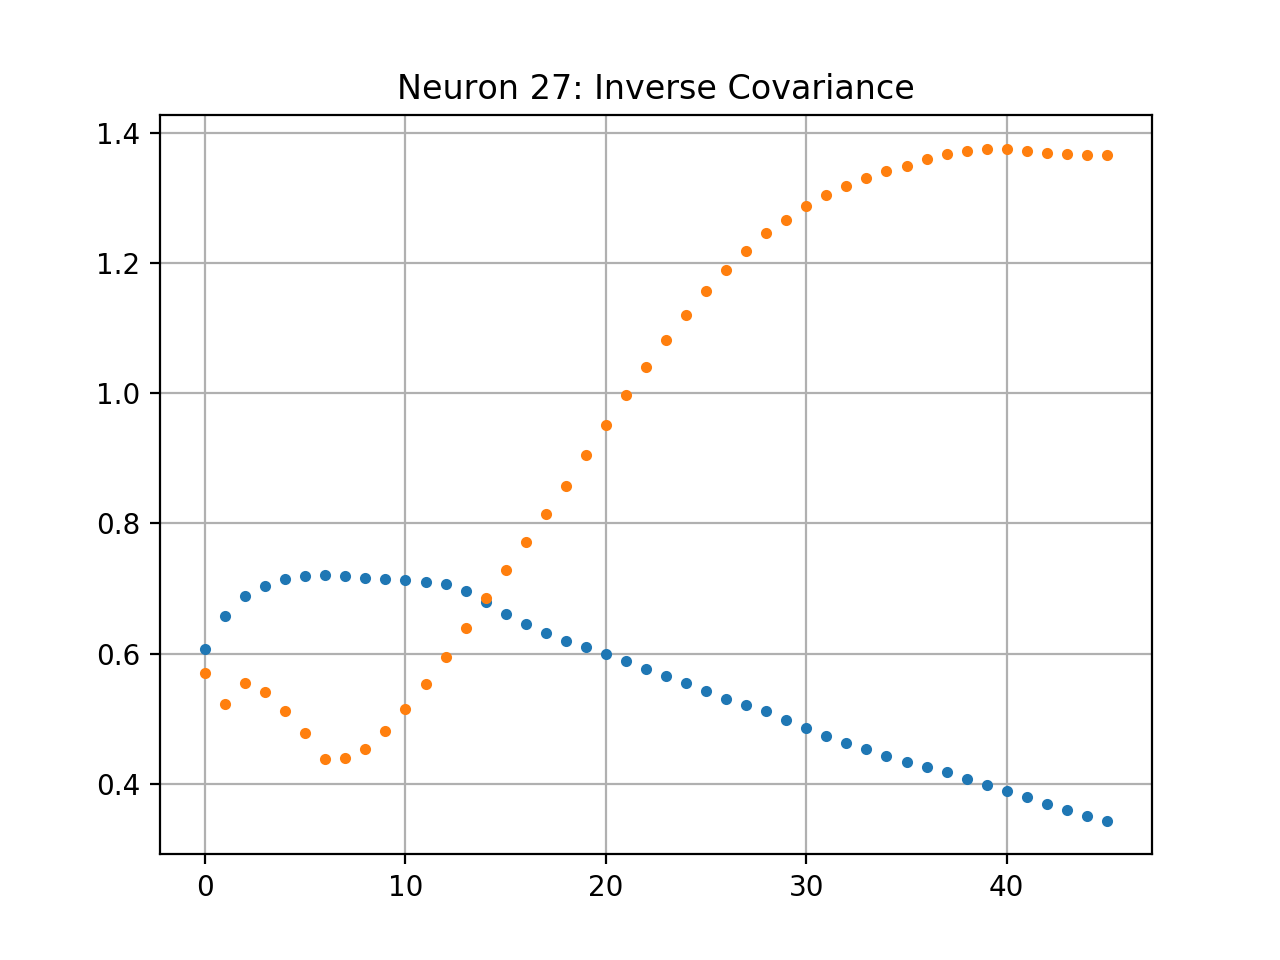

<IPython.core.display.Javascript object>


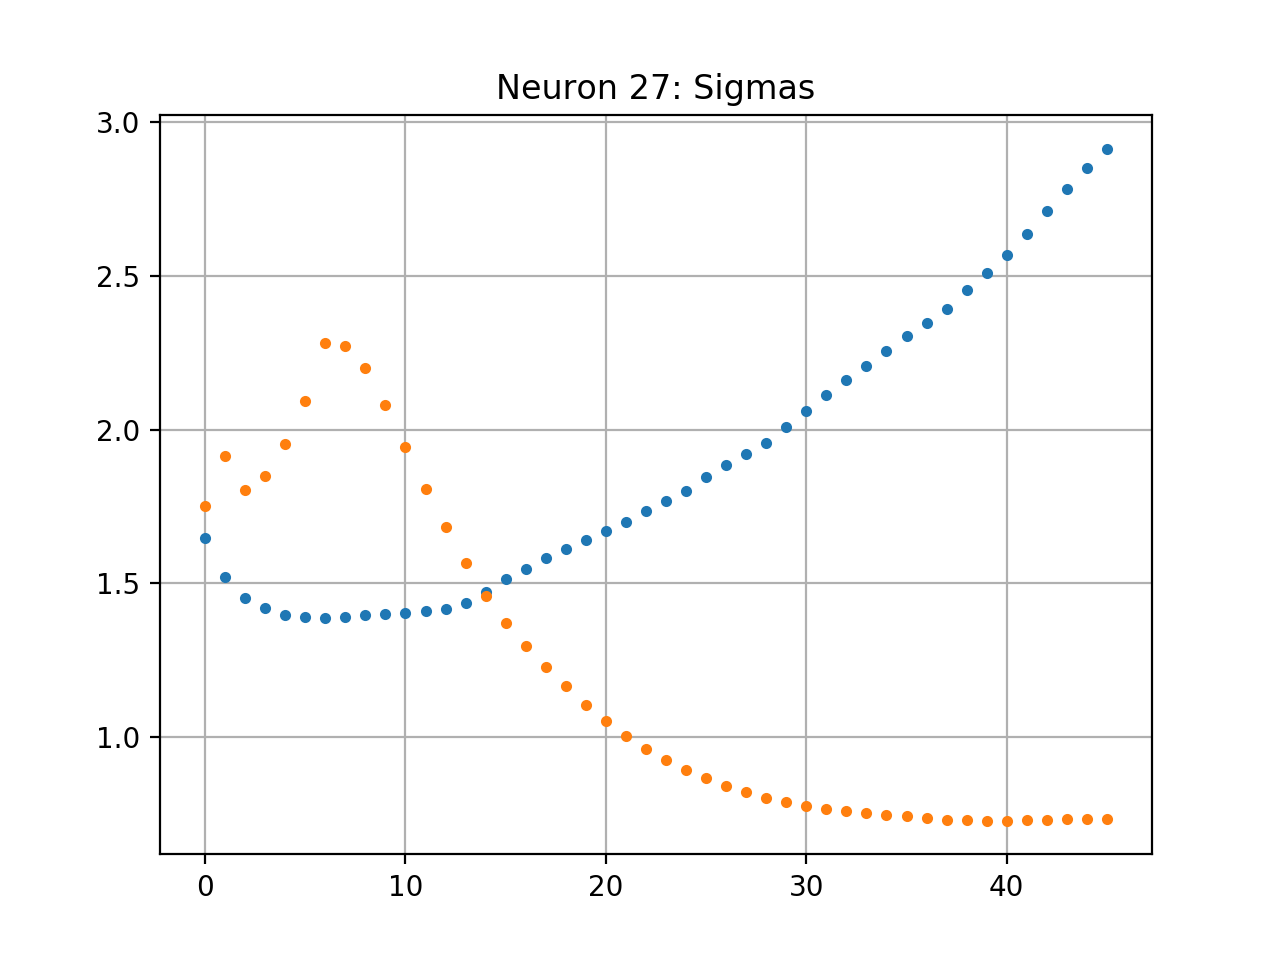

In [35]:
# check that inv covar has gone up, sigmas down, and trace down if covar_type=='full'
for k in fgn_train_res['histories'].keys():
    if 'inv_covar' in k:
        print(k)
        s = fgn_train_res['histories'][k].shape
        print(s)
        neurons =  np.random.choice(range(s[1]),2, replace=False)
        print("plotting neurons:", neurons)
        if covar_type == 'diag':
            # for each neuron
            for i in neurons:
                plt.plot(fgn_train_res['histories'][k][:,i].reshape(s[0],np.prod(s[2:])), marker='.', linestyle=' ')
                plt.title('Neuron {}: Inverse Covariance'.format(i))
                plt.grid()
                plt.show()
                
                plt.plot(1.0/fgn_train_res['histories'][k][:,i].reshape(s[0],np.prod(s[2:])), marker='.', linestyle=' ')
                plt.title('Neuron {}: Sigmas'.format(i))
                plt.grid()
                plt.show()
        
        elif covar_type == 'full':
            # plot trace of each neuron
            for i in neurons:
                # plot trace
                trace = [np.einsum('ik,ik->', p, p) for p in fgn_train_res['histories'][k][:,i]]
                plt.plot(trace, marker='.', linestyle=' ')
            plt.title('Neuron{}: Trace'.format(i))
            plt.grid()
            plt.show()
        
        
        else:
            # covar_type == 'sphere'
            plt.plot(fgn_train_res['histories'][k], marker='.', linestyle=' ',)
            plt.title('Inverse Covariance')
            plt.grid()
            plt.show()
            
            plt.plot(1.0/fgn_train_res['histories'][k], marker='.', linestyle=' ')
            plt.title('Sigma')

            plt.grid()
            plt.show()

In [36]:
# ### what about a converted net
# # Initialize the fgn network
# print("hidden layers:", hidden_l_nums)
# print("drop prob:", drop_p)
# converted_fgn_model = fgnl.Feedforward_FGN_net(in_feats=2, out_feats=2, hidden_l_nums=hidden_l_nums, drop_p=drop_p).to(device)

In [37]:
# fgnl.convert_classic_to_fgn(classic_model, converted_fgn_model)

In [38]:
# # make sure performance after isnt crap
# fgn_test_res_post = fgnh.test(converted_fgn_model, my_dataloader, 
#                      fgn_cross_ent_loss, verbose=True, 
#                      pred_func=fgnh.cross_ent_pred_accuracy)

In [39]:
# # compute predictions
# converted_fgn_model.eval()
# converted_fgn_heatmap_preds = converted_fgn_model(heatmap_inputs.to(device))
# converted_fgn_heatmap_preds = converted_fgn_heatmap_preds.cpu().detach().numpy()
# # apply softmax for probs
# converted_fgn_heatmap_preds_softmax = np.array([np.exp(x)/sum(np.exp(x)) for x in converted_fgn_heatmap_preds.astype('float128')])

In [40]:
# levels = np.arange(-0.0, 1.0+0.001, 10**(-2))
# ticks = levels[::5]

# plt.contourf(X1s, X2s, np.reshape(converted_fgn_heatmap_preds_softmax[:,0], np.shape(X1s) ),levels=levels, cmap= mpl.cm.RdYlBu_r)
# plt.colorbar(ticks=ticks)

# # # uncomment if you want to see the data and tighten the window
# # plt.scatter(samples_x_1, samples_y_1, alpha=0.1, c='gray')
# # plt.scatter(samples_x_2, samples_y_2, alpha=0.1, c='gray')
# # plt.axis([-1.5,2.5, -1, 1.5])


# plt.grid(True)
# plt.show()

In [41]:
# ### what are the sigmas
# for n,p in converted_fgn_model.named_parameters():
#     if 'sigmas' in n:
#         print(p)

In [42]:
# adjust sigmas

In [43]:
# def adjust_sigma_pred_func(fgn_model, dataloader, pred_func, verbose):
    
#     ###
#     # adjusts the sigmas of the given fgn model so that the pred accuracy over the dataset is max
#     ###
    
#     # best pred acc yet
#     fgn_test_res = fgnh.test(fgn_model, dataloader, 
#                              (lambda model, output, target:torch.tensor(0)), verbose=verbose, 
#                              pred_func=pred_func)
#     best_pred = fgn_test_res['test_accuracy']
#     # best sigma multiplier yet
#     best_sig_mult = 1.0
#     # lower bound for sigma mult
#     lower_bound = 0.0
#     # uper bound for sigma
#     upper_bound = float('Inf')
    
#     # max number of values to test
#     max_iter = 25
    
#     # first double sigmas until performance decreases
#     for ite in range(max_iter):
#         # new val to test
#         cur_sig_mult = 2.0*best_sig_mult
#         if verbose: print(ite, "testing", cur_sig_mult)
        
#         # apply multiplier
#         # given an fgn model, multiplies all the sigmas by a value
#         for p in fgn_model.modules():
#             if isinstance(p, fgnl.FGN_layer):
#                 p.sigmas = torch.nn.Parameter(p.sigmas*cur_sig_mult)
    
#         # test
#         fgn_test_res = fgnh.test(fgn_model, dataloader, 
#                              (lambda model, output, target:torch.tensor(0)), verbose=verbose, 
#                              pred_func=pred_func)
#         cur_pred = fgn_test_res['test_accuracy']
        
#         # reset sigmas 
#         for p in fgn_model.modules():
#             if isinstance(p, fgnl.FGN_layer):
#                 p.sigmas = torch.nn.Parameter(p.sigmas/cur_sig_mult)
                
#         if cur_pred > best_pred:
#             if verbose: print("new best during doubling")
#             # new best
#             best_pred = cur_pred
#             best_sig_mult = cur_sig_mult
#             # increase lower bound
#             lower_bound = cur_sig_mult
#         else:
#             # new upper bound
#             upper_bound = cur_sig_mult
#             # and exit loop
#             break
            
            
#     # next half sigmas until performance decreases
#     for ite in range(max_iter):
#         # new val to test
#         cur_sig_mult = 0.5*best_sig_mult
#         if verbose: print(ite, "testing", cur_sig_mult)
        
#         # apply multiplier
#         # given an fgn model, multiplies all the sigmas by a value
#         for p in fgn_model.modules():
#             if isinstance(p, fgnl.FGN_layer):
#                 p.sigmas = torch.nn.Parameter(p.sigmas*cur_sig_mult)
    
#         # test
#         fgn_test_res = fgnh.test(fgn_model, dataloader, 
#                              (lambda model, output, target:torch.tensor(0)), verbose=verbose, 
#                              pred_func=pred_func)
#         cur_pred = fgn_test_res['test_accuracy']
        
#         # reset sigmas 
#         for p in fgn_model.modules():
#             if isinstance(p, fgnl.FGN_layer):
#                 p.sigmas = torch.nn.Parameter(p.sigmas/cur_sig_mult)
                
#         if cur_pred >= (1.0-1e-3)*best_pred:
#             if verbose: print("new best during halfing")
#             # new best
#             best_pred = cur_pred
#             best_sig_mult = cur_sig_mult
#             # new upper bound
#             upper_bound = cur_sig_mult
#         else:
#             # increase lower bound
#             lower_bound = cur_sig_mult
#             # and exit loop
#             break
    
#     # now that we have a real bounds, search by dichotomie
#     for ite in range(max_iter):

#         # new val to test
#         cur_sig_mult = 0.5*(upper_bound+lower_bound)
#         if verbose: print(ite, "testing", cur_sig_mult)
        
#         # apply multiplier
#         # given an fgn model, multiplies all the sigmas by a value
#         for p in fgn_model.modules():
#             if isinstance(p, fgnl.FGN_layer):
#                 p.sigmas = torch.nn.Parameter(p.sigmas*cur_sig_mult)
    
#         # test
#         fgn_test_res = fgnh.test(fgn_model, dataloader, 
#                              (lambda model, output, target:torch.tensor(0)), verbose=verbose, 
#                              pred_func=pred_func)
#         cur_pred = fgn_test_res['test_accuracy']
        
#         # reset sigmas 
#         for p in fgn_model.modules():
#             if isinstance(p, fgnl.FGN_layer):
#                 p.sigmas = torch.nn.Parameter(p.sigmas/cur_sig_mult)
                
#         if cur_pred >= (1.0-1e-3)*best_pred:
#             if verbose: print("new best during dicho")
#             # new low bound
#             if cur_sig_mult > best_sig_mult:
#                 lower_bound = cur_sig_mult
#             # new upper bound
#             else:
#                 upper_bound = cur_sig_mult
#             # new best
#             best_pred = cur_pred
#             best_sig_mult = cur_sig_mult
                
#         else:
#             # new low bound
#             if cur_sig_mult < best_sig_mult:
#                 lower_bound = cur_sig_mult
#             # new upper bound
#             else:
#                 upper_bound = cur_sig_mult
            
#     # apply best mult
#     if verbose: print("best multiplier:", best_sig_mult)
#     for p in fgn_model.modules():
#         if isinstance(p, fgnl.FGN_layer):
#             p.sigmas = torch.nn.Parameter(p.sigmas*best_sig_mult)
            
#     return None

In [44]:
# adjust_sigma_pred_func(converted_fgn_model, my_dataloader, fgnh.cross_ent_pred_accuracy, verbose=True)

In [45]:
# # make sure performance after isnt crap
# fgn_test_res_post = fgnh.test(converted_fgn_model, my_dataloader, 
#                      fgn_cross_ent_loss, verbose=True, 
#                      pred_func=fgnh.cross_ent_pred_accuracy)

In [46]:
## post adjusting heatmap

In [47]:
# # compute predictions
# converted_fgn_model.eval()
# converted_fgn_heatmap_preds = converted_fgn_model(heatmap_inputs.to(device))
# converted_fgn_heatmap_preds = converted_fgn_heatmap_preds.cpu().detach().numpy()
# # apply softmax for probs
# converted_fgn_heatmap_preds_softmax = np.array([np.exp(x)/sum(np.exp(x)) for x in converted_fgn_heatmap_preds.astype('float128')])

In [48]:
# levels = np.arange(-0.0, 1.0+0.001, 10**(-2))
# ticks = levels[::5]

# plt.contourf(X1s, X2s, np.reshape(converted_fgn_heatmap_preds_softmax[:,0], np.shape(X1s) ),levels=levels, cmap= mpl.cm.RdYlBu_r)
# plt.colorbar(ticks=ticks)

# # # uncomment if you want to see the data and tighten the window
# # plt.scatter(samples_x_1, samples_y_1, alpha=0.1, c='gray')
# # plt.scatter(samples_x_2, samples_y_2, alpha=0.1, c='gray')
# # plt.axis([-1.5,2.5, -1, 1.5])

# plt.grid(True)
# plt.show()

In [49]:
# ### what are the sigmas
# for n,p in converted_fgn_model.named_parameters():
#     if 'sigmas' in n:
#         print(p)

In [50]:
# next idea: use grad descent to adjust sigmas and centers 

In [51]:
# for p in converted_fgn_model.named_parameters():
#     if 'weights' in p[0]:
#         print(p[1])

In [52]:
# # converted_fgn_sigmas_optimizer = optim.RMSprop([p[1] for p in converted_fgn_model.named_parameters()
# #                                       if p[1].requires_grad and ('censdfsdfsdfters' in p[0] or 'sigmas' in p[0])], 
# #                                      momentum=0.5)

# # converted_fgn_sigmas_optimizer = optim.RMSprop(filter(lambda p: (p[1].requires_grad),
# #                                                                  converted_fgn_model.named_parameters()),momentum=0.5)

# converted_fgn_sigmas_optimizer = optim.RMSprop([p[1] for p in converted_fgn_model.named_parameters()
#                                       if (p[1].requires_grad and 
#                                           (('weight' in p[0] and not 'weights' in p[0]) or 'bias' in p[0] 
#                                            or 'sigmas' in p[0] 
#                                            or 'centers'in p[0]))], 
#                                      momentum=0.5)

In [53]:
# converted_fgn_train_res = fgnh.train(converted_fgn_model, my_dataloader, 
#                              fgn_cross_ent_loss, converted_fgn_sigmas_optimizer, epochs, save_hist=2, verbose=True, 
#                              pred_func=fgnh.cross_ent_pred_accuracy, test_loader=my_test_dataloader)

In [54]:
# # compute predictions
# converted_fgn_model.eval()
# converted_fgn_heatmap_preds = converted_fgn_model(heatmap_inputs.to(device))
# converted_fgn_heatmap_preds = converted_fgn_heatmap_preds.cpu().detach().numpy()
# # apply softmax for probs
# converted_fgn_heatmap_preds = np.array([np.exp(x)/sum(np.exp(x)) for x in converted_fgn_heatmap_preds.astype('float128')])

In [55]:
# levels = np.arange(-0.0, 1.0+0.001, 10**(-2))
# ticks = levels[::5]

# plt.contourf(X1s, X2s, np.reshape(converted_fgn_heatmap_preds[:,0], np.shape(X1s) ),levels=levels, cmap= mpl.cm.RdYlBu_r)
# plt.colorbar(ticks=ticks)

# # # uncomment if you want to see the data and tighten the window
# # plt.scatter(samples_x_1, samples_y_1, alpha=0.1, c='gray')
# # plt.scatter(samples_x_2, samples_y_2, alpha=0.1, c='gray')
# # plt.axis([-1.5,2.5, -1, 1.5])

# plt.grid(True)
# plt.show()

In [56]:
# ### what are the sigmas
# for n,p in converted_fgn_model.named_parameters():
#     if 'sigmas' in n:
#         print(p)

In [57]:
# # make sure performance after isnt crap
# fgn_test_res_post = fgnh.test(converted_fgn_model, my_dataloader, 
#                      fgn_cross_ent_loss, verbose=True, 
#                      pred_func=fgnh.cross_ent_pred_accuracy)

In [58]:
# for p in converted_fgn_model.named_parameters():
#     if 'weights' in p[0]:
#         print(p[1])